# Training and validation images

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


DATA_DIRECTORY = '../../../Images'
BATCH_SIZE_FOR_IMAGES = 32
NUMBER_CLASSES = 0
CLASS_NAMES = []
SIZE = 224
IMAGE_SIZE = (SIZE, SIZE)

def get_data_for(name: str) -> ImageDataGenerator:
    return ImageDataGenerator(preprocessing_function=preprocess_input, 
        validation_split=0.2,
        shear_range=10.0,
        zoom_range=0.01,
        horizontal_flip=True,
        rotation_range=15,
        width_shift_range=10,
        height_shift_range=10,  
    ).flow_from_directory(
        directory=DATA_DIRECTORY,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE_FOR_IMAGES,
        shuffle=True,
        subset=name,
    )


training = get_data_for("training")
validation = get_data_for("validation")

NUMBER_CLASSES = len(training.class_indices)
CLASS_NAMES = list(training.class_indices.keys())

print("Number of classes: ", NUMBER_CLASSES)
print("Class names: ", CLASS_NAMES)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Number of classes:  12
Class names:  ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


## Show images

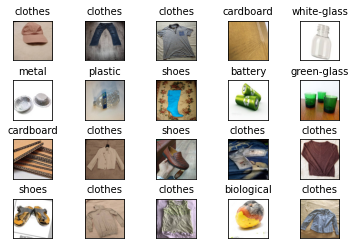

In [3]:
import matplotlib.pyplot as plt

TOTAL_IMAGES = 20

for image, label in training:
  for i in range(TOTAL_IMAGES):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i] / 2 + 0.5)  
    plt.subplots_adjust(wspace=0.5, hspace=0.5)                              
    plt.title(CLASS_NAMES[label[i].argmax()], fontsize=10)         
  break 
plt.show()

# Neural Network Architecture

In [4]:
NEURAL_NETWORK = 'Xception-DA'

In [4]:

from tensorflow.keras.applications import Xception
from tensorflow import keras

IMAGE_SHAPE = (SIZE, SIZE, 3)

model_transfer_learning = Xception(
    input_shape=IMAGE_SHAPE, weights="imagenet", include_top=False
)
model_transfer_learning.trainable = False

IMAGE_INPUT = keras.Input(shape=IMAGE_SHAPE)
DROP_RATE=0.3
NUMBER_NEURONS=32

base = model_transfer_learning(IMAGE_INPUT, training=False)
pooling = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(NUMBER_NEURONS, activation='relu')(pooling)
dropout = keras.layers.Dropout(DROP_RATE)(inner)
output = keras.layers.Dense(NUMBER_CLASSES)(dropout)

model = keras.Model(IMAGE_INPUT, output)


2022-10-11 12:44:22.816240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 12:44:36.283327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


83683744/83683744 [==============================] - 1s 0us/step


## Summary and plot model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                             

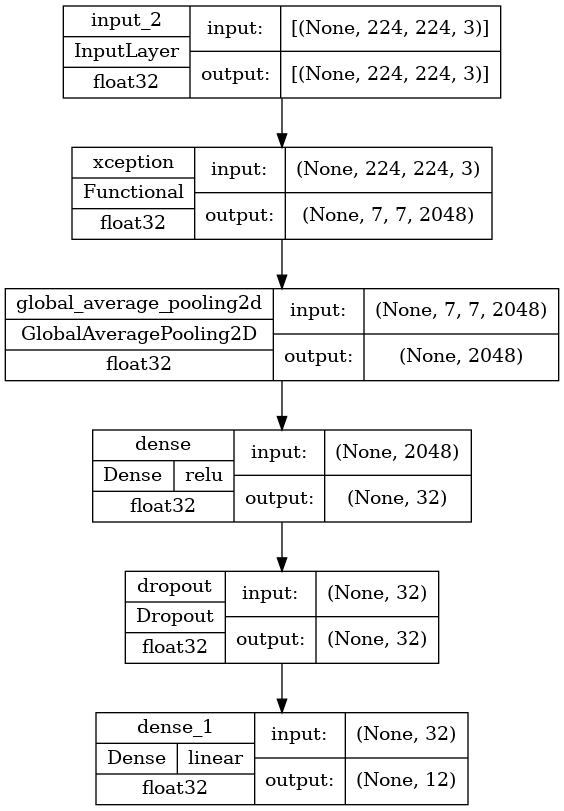

In [7]:
model.summary()
keras.utils.plot_model(
   model,
   to_file=f'{NEURAL_NETWORK}.png',
   show_shapes=True,
    show_dtype=True,
    show_layer_names=True,   
    dpi=96,
    show_layer_activations=True)

# Training parameters

In [5]:
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

## Compilation and Training

In [6]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"../Logs/{TRAINING_NAME}"),
    ],
)
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/10
388/388 [==============================] - 949s 2s/step - loss: 0.6747 - accuracy: 0.8032 - val_loss: 0.3518 - val_accuracy: 0.8906
Epoch 2/10
388/388 [==============================] - 789s 2s/step - loss: 0.3717 - accuracy: 0.8873 - val_loss: 0.2986 - val_accuracy: 0.9006
Epoch 3/10
388/388 [==============================] - 737s 2s/step - loss: 0.3093 - accuracy: 0.9059 - val_loss: 0.2726 - val_accuracy: 0.9090
Epoch 4/10
388/388 [==============================] - 694s 2s/step - loss: 0.2694 - accuracy: 0.9167 - val_loss: 0.2744 - val_accuracy: 0.9103
Epoch 5/10
388/388 [==============================] - 656s 2s/step - loss: 0.2514 - accuracy: 0.9246 - val_loss: 0.2694 - val_accuracy: 0.9097
Epoch 6/10
388/388 [==============================] - 649s 2s/step -

2022-10-11 12:47:31.874754: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-11 12:47:46.924000: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Evaluate model

In [7]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100.0):.3f}%\nLoss: {(loss*100):.3f}%')


97/97 [==============================] - 123s 1s/step - loss: 0.2455 - accuracy: 0.9132
Accuracy: 91.323%
Loss: 24.551%


## Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix_for(model, data):
    cm = confusion_matrix(data.classes, np.argmax(model.predict(data), axis=1))    
    df_cm = pd.DataFrame(cm, index=data.class_indices.keys(), columns=data.class_indices.keys())
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    plt.title("Validation")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

97/97 [==============================] - 128s 1s/step


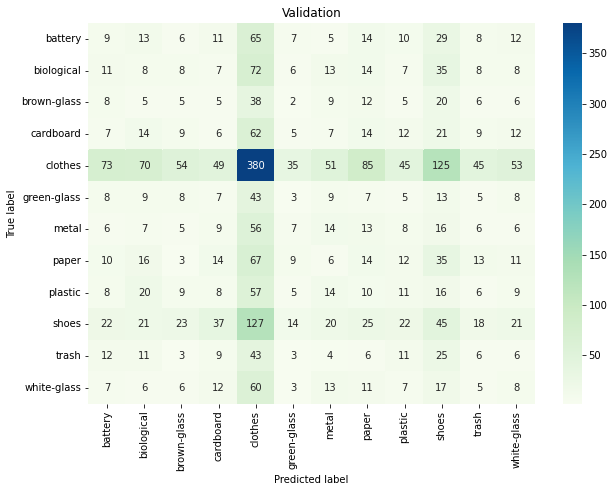

In [9]:
plot_confusion_matrix_for(model, validation)

## Save model

In [16]:
model.save(f"{TRAINING_NAME}-MODEL.h5")

## Load model

In [7]:
import tensorflow.keras as keras
model = keras.models.load_model(f"{TRAINING_NAME}-MODEL.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                             

# Fine tuning taken from [keras](https://keras.io/guides/transfer_learning/)

In [8]:
NEURAL_NETWORK = 'Xception-DA-FT'

In [9]:
LEARNING_RATE = 1e-5
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

In [10]:
model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                             

In [11]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"../Logs/{TRAINING_NAME}"),
    ],
)
print(f"--- {(time.time() - start_time):2f} seconds ---")

Epoch 1/10
388/388 [==============================] - 1200s 3s/step - loss: 0.1412 - accuracy: 0.9534 - val_loss: 0.2305 - val_accuracy: 0.9313
Epoch 2/10
388/388 [==============================] - 1090s 3s/step - loss: 0.1025 - accuracy: 0.9669 - val_loss: 0.2047 - val_accuracy: 0.9300
Epoch 3/10
388/388 [==============================] - 673s 2s/step - loss: 0.0828 - accuracy: 0.9711 - val_loss: 0.2018 - val_accuracy: 0.9348
Epoch 4/10
388/388 [==============================] - 1052s 3s/step - loss: 0.0669 - accuracy: 0.9766 - val_loss: 0.1757 - val_accuracy: 0.9465
Epoch 5/10
388/388 [==============================] - 998s 3s/step - loss: 0.0603 - accuracy: 0.9783 - val_loss: 0.2091 - val_accuracy: 0.9423
Epoch 6/10
388/388 [==============================] - 651s 2s/step

2022-10-14 16:09:47.189466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-14 16:10:01.405016: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-14 16:10:15.214689: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-14 16:10:22.062230: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-14 16:10:22.123785: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

## Evaluate the model

In [12]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100.0):.3f}%\nLoss: {(loss*100):.3f}%')

97/97 [==============================] - 129s 1s/step - loss: 0.2116 - accuracy: 0.9465
Accuracy: 94.645%
Loss: 21.159%


## Matrix confusion

97/97 [==============================] - 113s 1s/step


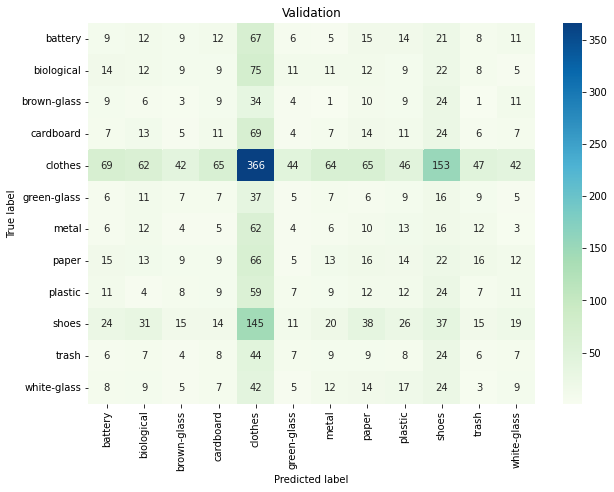

In [14]:
plot_confusion_matrix_for(model, validation)

# Predictions

## Without fine tuning

1/1 [==============================] - 2s 2s/step


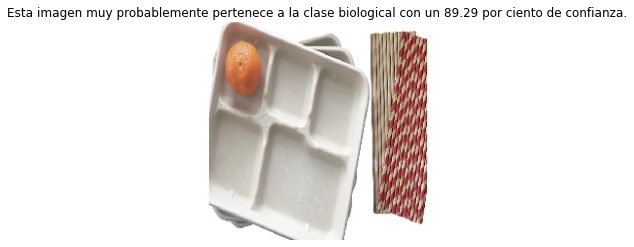

1/1 [==============================] - 0s 27ms/step


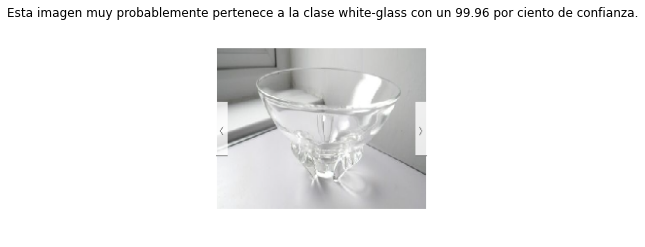

1/1 [==============================] - 0s 27ms/step


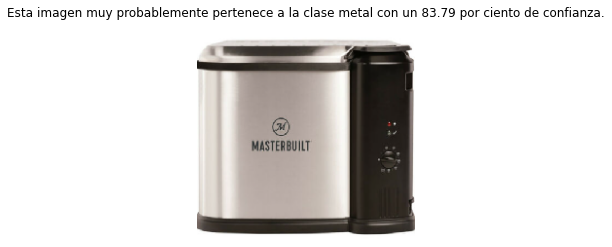

1/1 [==============================] - 0s 25ms/step


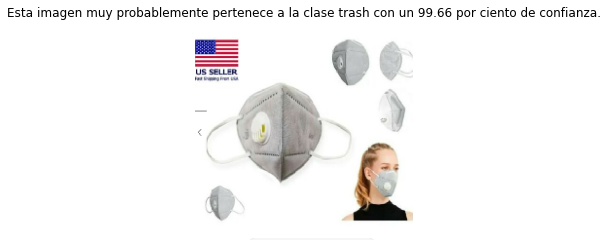

1/1 [==============================] - 0s 27ms/step


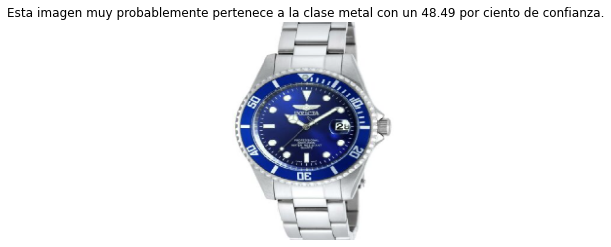

1/1 [==============================] - 0s 25ms/step


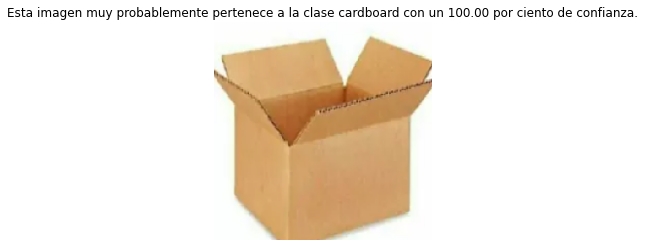

1/1 [==============================] - 0s 27ms/step


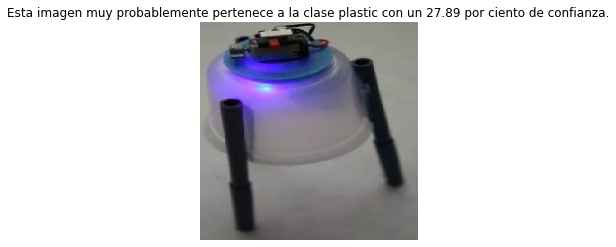

1/1 [==============================] - 0s 26ms/step


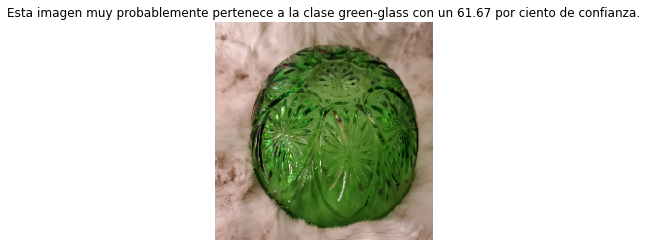

1/1 [==============================] - 0s 27ms/step


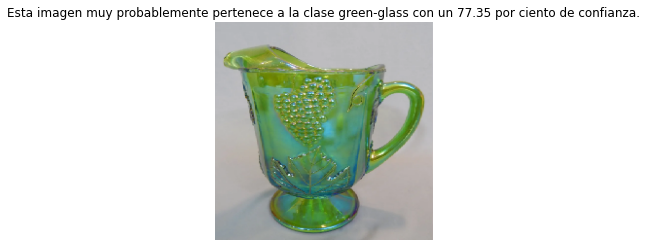

In [11]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()


## With fine tuning

1/1 [==============================] - 2s 2s/step


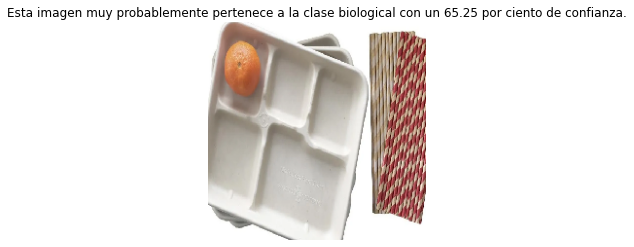

1/1 [==============================] - 0s 26ms/step


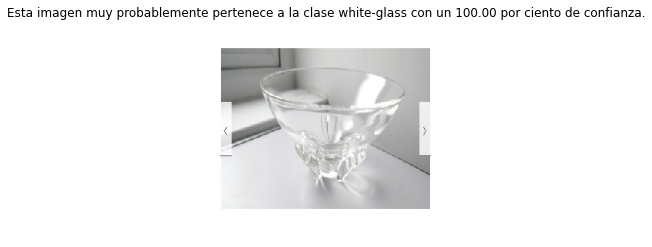

1/1 [==============================] - 0s 28ms/step


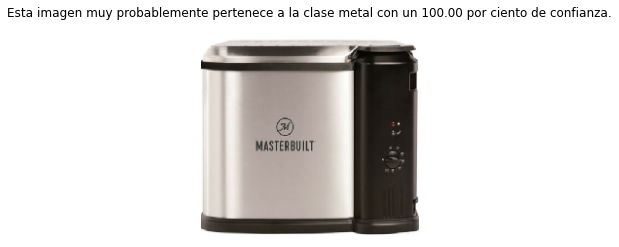

1/1 [==============================] - 0s 26ms/step


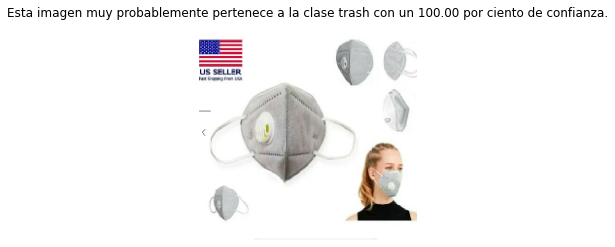

1/1 [==============================] - 0s 28ms/step


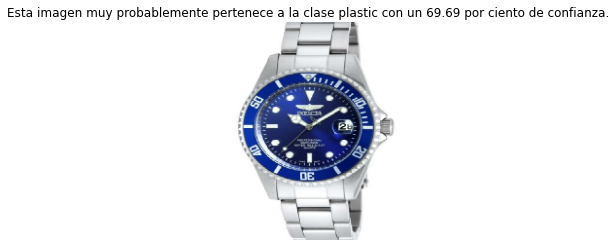

1/1 [==============================] - 0s 27ms/step


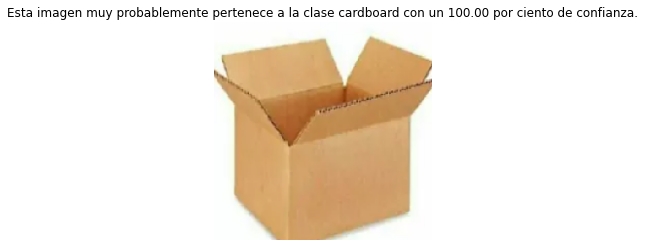

1/1 [==============================] - 0s 27ms/step


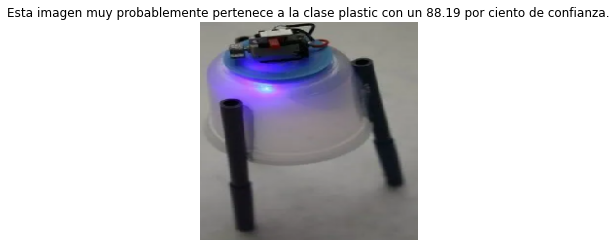

1/1 [==============================] - 0s 27ms/step


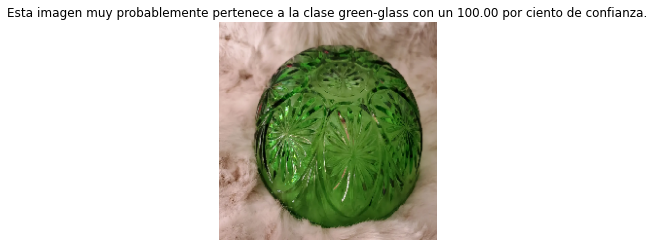

1/1 [==============================] - 0s 26ms/step


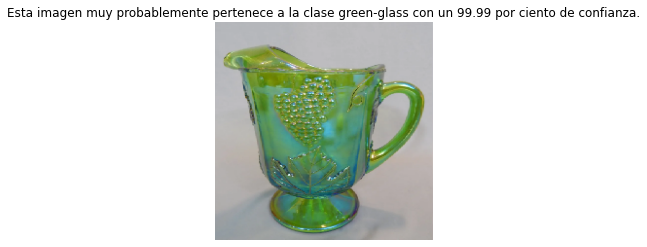

In [15]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()
